<a href="https://colab.research.google.com/github/Ris15hab/IPD_classifier/blob/main/WasteClassifier2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/VIJAY-GADRE/Waste_Classification_using_ResNet152.git

Cloning into 'Waste_Classification_using_ResNet152'...
remote: Enumerating objects: 5107, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 5107 (delta 20), reused 43 (delta 20), pack-reused 5064
Receiving objects: 100% (5107/5107), 197.01 MiB | 33.33 MiB/s, done.
Resolving deltas: 100% (21/21), done.
Updating files: 100% (5084/5084), done.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, optimizers, Sequential

In [ ]:
img_height = 180
img_width = 180

In [ ]:
data_path = '/content/Waste_Classification_using_ResNet152/WasteImagesDataset'

In [ ]:
data_train = tf.keras.utils.image_dataset_from_directory(
    data_path,
    image_size=(img_width,img_height),
    shuffle=True,
    batch_size=32,
    validation_split=0.2,
    subset="training",
    seed=42,
)

Found 5078 files belonging to 9 classes.
Using 4063 files for training.


In [ ]:
data_temp = tf.keras.utils.image_dataset_from_directory(
    data_path,
    image_size=(img_width,img_height),
    shuffle=True,
    batch_size=32,
    validation_split=0.2,
    subset="validation",
    seed=42,
)

Found 5078 files belonging to 9 classes.
Using 1015 files for validation.


In [ ]:
train_size = int(len(data_temp)*.5)
val_size = int(len(data_temp)*.5)

In [ ]:
data_test = data_temp.take(train_size)
data_val = data_temp.skip(train_size).take(val_size)

In [ ]:
classes = data_train.class_names
classes

['Aluminium',
 'Carton',
 'Glass',
 'Organic Waste',
 'Other Plastics',
 'Paper and Cardboard',
 'Plastic',
 'Textiles',
 'Wood']

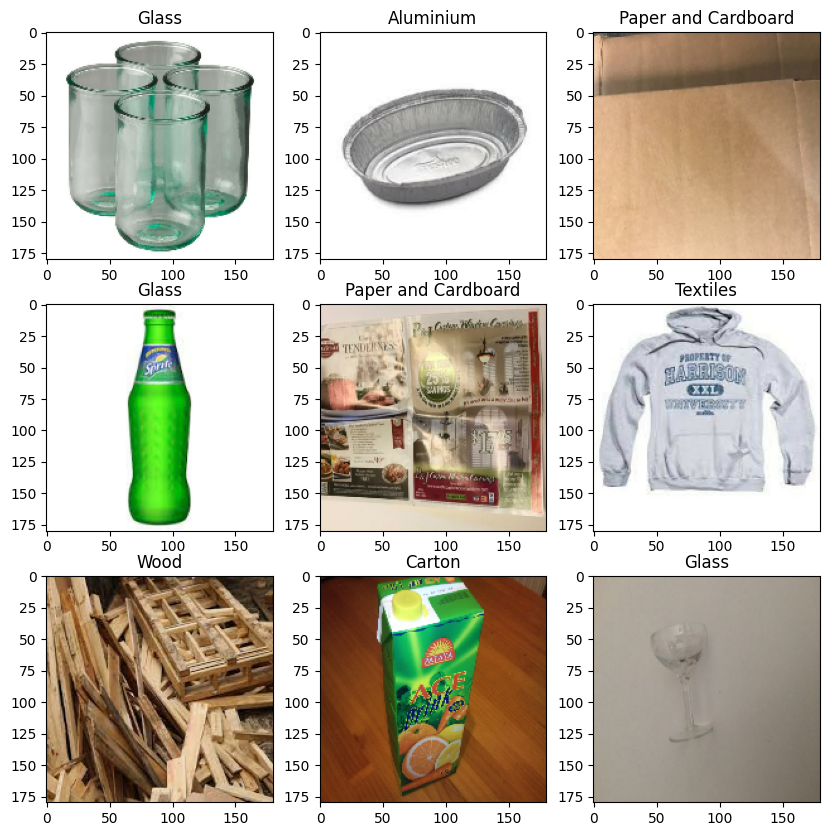

In [ ]:
plt.figure(figsize=(10,10))
for image, labels in data_train.skip(1).take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(classes[labels[i]])
plt.show()

In [ ]:
from collections import Counter
class_counter = Counter()

# Count the occurrences of each class label in the dataset
for _, labels in data_train:
    class_counter.update(labels.numpy())

# Print the frequency of each class
for class_label, count in class_counter.items():
    class_name = classes[class_label]
    print(f"Class: {class_name}, Frequency: {count}")

Class: Textiles, Frequency: 253
Class: Paper and Cardboard, Frequency: 1090
Class: Carton, Frequency: 263
Class: Plastic, Frequency: 404
Class: Wood, Frequency: 283
Class: Aluminium, Frequency: 631
Class: Glass, Frequency: 703
Class: Other Plastics, Frequency: 282
Class: Organic Waste, Frequency: 154


In [ ]:
class_counter = Counter()

for _, labels in data_test:
    class_counter.update(labels.numpy())

for class_label, count in class_counter.items():
    class_name = classes[class_label]
    print(f"Class: {class_name}, Frequency: {count}")

Class: Paper and Cardboard, Frequency: 157
Class: Organic Waste, Frequency: 29
Class: Other Plastics, Frequency: 30
Class: Aluminium, Frequency: 64
Class: Wood, Frequency: 25
Class: Plastic, Frequency: 52
Class: Textiles, Frequency: 50
Class: Glass, Frequency: 71
Class: Carton, Frequency: 34


In [ ]:
class_counter = Counter()

for _, labels in data_val:
    class_counter.update(labels.numpy())

for class_label, count in class_counter.items():
    class_name = classes[class_label]
    print(f"Class: {class_name}, Frequency: {count}")

Class: Textiles, Frequency: 41
Class: Aluminium, Frequency: 60
Class: Glass, Frequency: 75
Class: Paper and Cardboard, Frequency: 154
Class: Wood, Frequency: 40
Class: Plastic, Frequency: 42
Class: Carton, Frequency: 39
Class: Other Plastics, Frequency: 26
Class: Organic Waste, Frequency: 26


In [ ]:
rescale_layer = tf.keras.layers.Rescaling(scale=1./255)

In [ ]:
data_train_rescaled = data_train.map(lambda x, y: (rescale_layer(x), y))
data_val_rescaled = data_val.map(lambda x, y: (rescale_layer(x), y))
data_test_rescaled = data_test.map(lambda x, y: (rescale_layer(x), y))

In [ ]:
pretrained_model_efficientb0 = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(180,180,3),
    classes=len(classes),
    classifier_activation="softmax",
)

for layer in pretrained_model_efficientb0.layers:
    layer.trainable=False

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
model = Sequential([
    pretrained_model_efficientb0,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='swish'),
    layers.Dropout(0.3),
    layers.Dense(9, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 6, 6, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 9)                 4617      
                                                                 
Total params: 4710060 (17.97 MB)
Trainable params: 66048

In [ ]:
model.compile(
    optimizer=optimizers.legacy.Adam(learning_rate=0.002),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['acc']
)

In [ ]:
history = model.fit(
    data_train,
    validation_data=data_val,
    epochs = 15
)

Epoch 1/15
127/127 [==============================] - 25s 118ms/step - loss: 0.4388 - acc: 0.8565 - val_loss: 0.3006 - val_acc: 0.8807
Epoch 2/15
127/127 [==============================] - 12s 86ms/step - loss: 0.1563 - acc: 0.9451 - val_loss: 0.2810 - val_acc: 0.9066
Epoch 3/15
127/127 [==============================] - 11s 86ms/step - loss: 0.1021 - acc: 0.9633 - val_loss: 0.2919 - val_acc: 0.9046
Epoch 4/15
127/127 [==============================] - 12s 87ms/step - loss: 0.0758 - acc: 0.9761 - val_loss: 0.3937 - val_acc: 0.8946
Epoch 5/15
127/127 [==============================] - 12s 86ms/step - loss: 0.0509 - acc: 0.9838 - val_loss: 0.2468 - val_acc: 0.9225
Epoch 6/15
127/127 [==============================] - 12s 87ms/step - loss: 0.0470 - acc: 0.9845 - val_loss: 0.2853 - val_acc: 0.9364
Epoch 7/15
127/127 [==============================] - 12s 86ms/step - loss: 0.0467 - acc: 0.9852 - val_loss: 0.3031 - val_acc: 0.9264
Epoch 8/15
127/127 [==============================] - 11s 85m

In [ ]:
model.evaluate(data_test)

16/16 [==============================] - 1s 69ms/step - loss: 0.5221 - acc: 0.9238


[0.5221152901649475, 0.923828125]

In [ ]:
history.history

{'loss': [0.4388290047645569,
  0.15634861588478088,
  0.10206462442874908,
  0.07580802589654922,
  0.05087652429938316,
  0.04700849950313568,
  0.046665143221616745,
  0.05049048736691475,
  0.0386003702878952,
  0.047747351229190826,
  0.04293470457196236,
  0.03856166824698448,
  0.0641741082072258,
  0.037082504481077194,
  0.03476860001683235],
 'acc': [0.8565099835395813,
  0.9451144337654114,
  0.9633275866508484,
  0.9761260151863098,
  0.9837558269500732,
  0.9844942092895508,
  0.9852325916290283,
  0.9847403168678284,
  0.9859709739685059,
  0.9876938462257385,
  0.9876938462257385,
  0.9884321689605713,
  0.9815407395362854,
  0.990155041217804,
  0.9896628260612488],
 'val_loss': [0.30057796835899353,
  0.28096631169319153,
  0.29186227917671204,
  0.39365580677986145,
  0.24676519632339478,
  0.28525418043136597,
  0.30306658148765564,
  0.21722011268138885,
  0.20034505426883698,
  0.24291470646858215,
  0.33892837166786194,
  0.3920549154281616,
  0.3000432848930359,


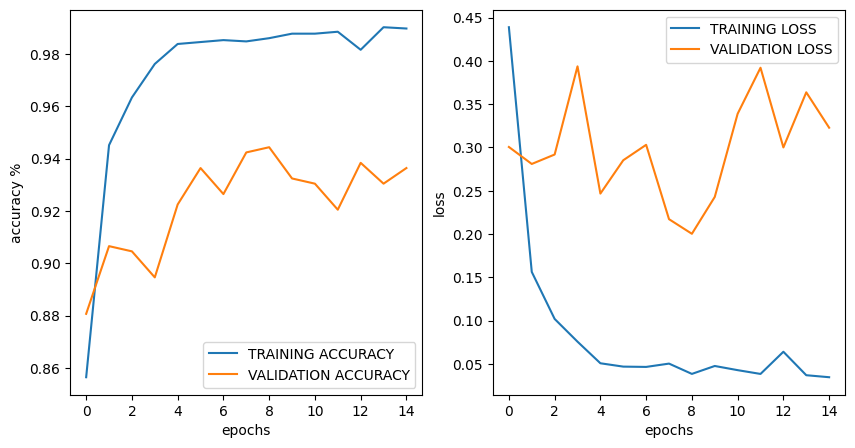

In [ ]:
temp = range(15)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(temp,history.history.get('acc'),label = 'TRAINING ACCURACY')
plt.plot(temp,history.history.get('val_acc'),label = 'VALIDATION ACCURACY')
plt.xlabel('epochs')
plt.ylabel('accuracy %')
plt.legend()

plt.subplot(1,2,2)
plt.plot(temp,history.history.get('loss'),label = 'TRAINING LOSS')
plt.plot(temp,history.history.get('val_loss'),label = 'VALIDATION LOSS')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [ ]:
images = []
labels = []
test_iterator = data_test.as_numpy_iterator()

for image, label in test_iterator:
    images.append(image)
    labels.append(label)

X_test = np.concatenate(images)
y_test = np.concatenate(labels)

print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")

X_test Shape: (512, 180, 180, 3)
y_test Shape: (512,)


In [ ]:
y_predicted = model.predict(X_test)
y_predicted

16/16 [==============================] - 2s 44ms/step


array([[1.3712018e-18, 7.7640245e-20, 1.6000128e-17, ..., 4.5345697e-15,
        5.3904905e-20, 1.1603664e-21],
       [2.7869679e-18, 2.3534192e-15, 2.2634345e-22, ..., 1.0680223e-20,
        1.0000000e+00, 8.0113016e-21],
       [2.2842656e-08, 1.1701357e-09, 9.9889696e-01, ..., 1.0855852e-03,
        8.9981506e-10, 1.1934547e-07],
       ...,
       [9.4129926e-10, 8.9711094e-12, 1.7534616e-08, ..., 1.0000000e+00,
        1.5415010e-11, 3.9533748e-10],
       [5.5246582e-14, 1.7898804e-09, 1.5288362e-12, ..., 2.5767283e-10,
        1.0615951e-15, 6.2123823e-10],
       [3.5589529e-15, 9.8139608e-11, 1.6479889e-11, ..., 7.1292225e-09,
        5.4919968e-13, 6.3562329e-11]], dtype=float32)

In [ ]:
y_predicted = list(np.argmax(element) for element in y_predicted)
y_predicted

[5,
 7,
 2,
 5,
 5,
 2,
 5,
 4,
 8,
 4,
 4,
 2,
 6,
 5,
 7,
 6,
 2,
 2,
 6,
 0,
 6,
 0,
 1,
 7,
 7,
 5,
 7,
 0,
 8,
 1,
 5,
 5,
 5,
 1,
 5,
 2,
 7,
 5,
 3,
 6,
 3,
 1,
 5,
 1,
 0,
 2,
 7,
 0,
 4,
 2,
 2,
 5,
 5,
 1,
 4,
 8,
 5,
 5,
 5,
 7,
 6,
 5,
 3,
 8,
 4,
 1,
 3,
 0,
 0,
 1,
 3,
 1,
 5,
 8,
 7,
 1,
 0,
 0,
 2,
 5,
 4,
 5,
 2,
 5,
 5,
 2,
 0,
 0,
 0,
 8,
 7,
 2,
 8,
 6,
 4,
 2,
 2,
 0,
 5,
 5,
 5,
 3,
 7,
 3,
 5,
 7,
 5,
 5,
 4,
 0,
 0,
 2,
 6,
 6,
 0,
 1,
 5,
 2,
 5,
 7,
 7,
 0,
 5,
 6,
 0,
 7,
 4,
 2,
 5,
 1,
 5,
 5,
 3,
 5,
 5,
 6,
 5,
 5,
 5,
 5,
 3,
 5,
 5,
 0,
 3,
 1,
 7,
 0,
 3,
 2,
 5,
 6,
 5,
 7,
 8,
 5,
 5,
 2,
 8,
 6,
 5,
 0,
 5,
 4,
 5,
 6,
 2,
 8,
 0,
 0,
 6,
 5,
 5,
 0,
 5,
 5,
 5,
 5,
 2,
 0,
 8,
 5,
 7,
 4,
 0,
 6,
 5,
 4,
 5,
 3,
 2,
 2,
 2,
 2,
 0,
 6,
 7,
 2,
 5,
 7,
 6,
 5,
 0,
 0,
 2,
 5,
 7,
 0,
 2,
 1,
 1,
 1,
 2,
 7,
 6,
 5,
 5,
 5,
 5,
 7,
 5,
 5,
 1,
 3,
 5,
 2,
 8,
 0,
 5,
 5,
 5,
 0,
 2,
 2,
 2,
 7,
 5,
 3,
 5,
 2,
 5,
 1,
 5,
 6,
 5,
 0,
 5,
 5,
 5,
 4,


In [ ]:
y_test

array([5, 7, 2, 5, 5, 2, 5, 4, 8, 4, 4, 2, 6, 5, 7, 6, 2, 2, 6, 0, 6, 0,
       1, 7, 7, 5, 7, 0, 8, 1, 5, 5, 5, 1, 5, 2, 7, 5, 3, 6, 3, 1, 5, 1,
       0, 2, 7, 0, 4, 2, 2, 5, 5, 1, 4, 8, 5, 5, 5, 7, 5, 5, 3, 8, 4, 1,
       3, 0, 0, 1, 3, 1, 5, 5, 7, 1, 0, 0, 2, 5, 4, 5, 2, 5, 5, 2, 0, 0,
       5, 8, 7, 2, 8, 5, 4, 2, 2, 0, 5, 5, 5, 3, 7, 3, 5, 7, 5, 8, 4, 6,
       0, 2, 6, 6, 0, 4, 0, 2, 5, 7, 5, 0, 5, 6, 0, 7, 4, 2, 5, 1, 5, 5,
       3, 5, 5, 6, 5, 5, 5, 5, 3, 5, 5, 0, 3, 1, 7, 0, 3, 2, 5, 6, 0, 7,
       8, 8, 5, 2, 8, 6, 5, 0, 5, 4, 5, 6, 2, 8, 0, 0, 6, 5, 5, 6, 5, 5,
       5, 5, 2, 0, 5, 5, 7, 4, 0, 6, 5, 4, 5, 3, 3, 2, 2, 6, 4, 6, 7, 2,
       5, 7, 6, 5, 0, 0, 2, 5, 7, 0, 2, 1, 1, 1, 2, 7, 6, 5, 5, 5, 5, 7,
       5, 5, 1, 3, 5, 2, 8, 0, 5, 5, 5, 0, 2, 2, 2, 7, 5, 3, 5, 2, 5, 1,
       5, 6, 5, 0, 5, 5, 5, 0, 2, 6, 0, 5, 5, 6, 5, 1, 0, 5, 5, 7, 4, 5,
       5, 5, 0, 5, 6, 8, 2, 6, 1, 8, 1, 6, 7, 5, 6, 2, 0, 2, 2, 7, 5, 2,
       6, 2, 0, 2, 5, 0, 7, 1, 5, 7, 2, 3, 6, 6, 4,

In [ ]:
from sklearn.metrics import classification_report
print(f"Classification Report:\n {classification_report(y_test,y_predicted)}")

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.92      0.87        63
           1       0.89      0.94      0.91        34
           2       0.97      0.93      0.95        72
           3       0.97      0.97      0.97        30
           4       0.94      0.91      0.93        35
           5       0.94      0.94      0.94       156
           6       0.96      0.92      0.94        50
           7       0.98      0.94      0.96        47
           8       0.79      0.76      0.78        25

    accuracy                           0.92       512
   macro avg       0.92      0.91      0.92       512
weighted avg       0.93      0.92      0.92       512



In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_predicted)
cm

array([[ 58,   1,   0,   0,   1,   3,   0,   0,   0],
       [  1,  32,   0,   0,   0,   1,   0,   0,   0],
       [  4,   0,  67,   0,   1,   0,   0,   0,   0],
       [  0,   0,   1,  29,   0,   0,   0,   0,   0],
       [  2,   1,   0,   0,  32,   0,   0,   0,   0],
       [  2,   1,   0,   0,   0, 146,   2,   1,   4],
       [  3,   0,   1,   0,   0,   0,  46,   0,   0],
       [  0,   1,   0,   1,   0,   0,   0,  44,   1],
       [  0,   0,   0,   0,   0,   6,   0,   0,  19]])

Text(95.7222222222222, 0.5, 'Truth')

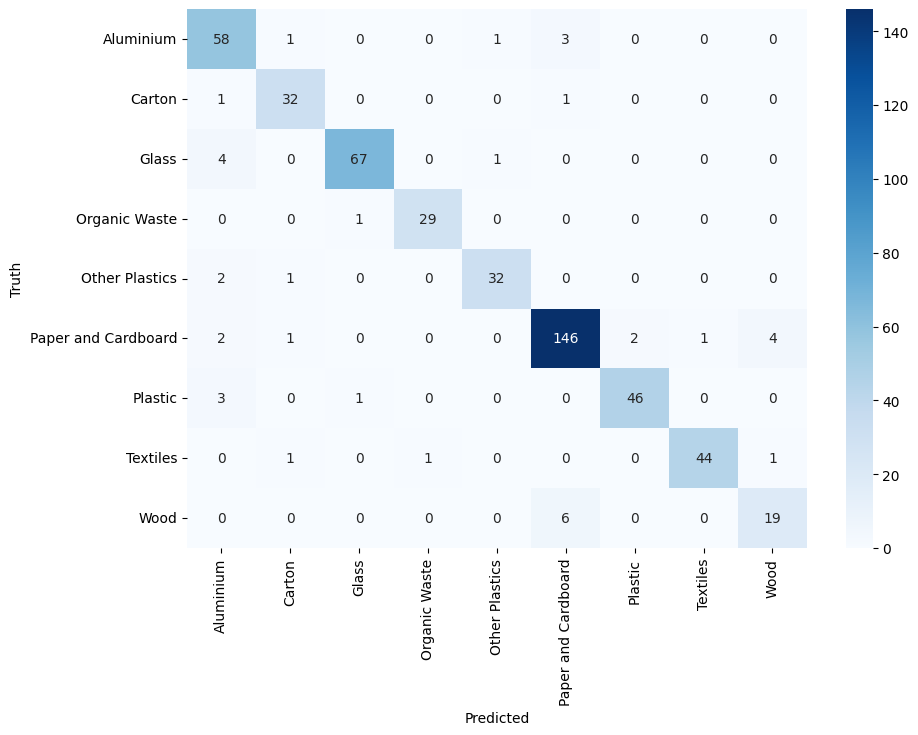

In [ ]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm ,annot=True ,fmt='d', cmap='Blues',xticklabels=classes,yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
model.save('model_ds1.keras')

In [ ]:
from keras.models import load_model

In [ ]:
temp = load_model('/content/model_ds1.keras')

In [ ]:
image_path = '/content/image2.jpeg'
image = tf.keras.utils.load_img(image_path, target_size = (180,180))
image_arr = tf.keras.utils.array_to_img(image)
image_fin = tf.expand_dims(image_arr,0)

FileNotFoundError: [Errno 2] No such file or directory: '/content/image2.jpeg'

In [ ]:
image_fin

<tf.Tensor: shape=(1, 180, 180, 3), dtype=uint8, numpy=
array([[[[ 95,  93,  98],
         [ 84,  82,  85],
         [ 80,  80,  82],
         ...,
         [ 74,  51,  43],
         [ 79,  56,  48],
         [ 92,  59,  50]],

        [[ 84,  83,  88],
         [ 98,  96,  99],
         [ 86,  86,  88],
         ...,
         [ 79,  54,  47],
         [ 85,  58,  49],
         [ 89,  61,  50]],

        [[ 87,  86,  91],
         [ 85,  83,  86],
         [ 99,  99, 101],
         ...,
         [ 75,  50,  45],
         [ 75,  52,  44],
         [ 79,  53,  40]],

        ...,

        [[ 69,  61,  50],
         [ 72,  64,  53],
         [ 69,  60,  51],
         ...,
         [ 86,  77,  72],
         [ 84,  75,  70],
         [ 84,  75,  70]],

        [[ 69,  61,  50],
         [ 70,  62,  51],
         [ 68,  60,  49],
         ...,
         [ 85,  76,  71],
         [ 81,  72,  67],
         [ 83,  72,  68]],

        [[ 69,  61,  50],
         [ 69,  61,  50],
         [ 74,  64

In [ ]:
result = np.argmax(temp.predict(image_fin))
result

1/1 [==============================] - 0s 27ms/step


1

In [ ]:
classes[result]

In [ ]:
image_path = '/content/image1.jpg'
image = tf.keras.utils.load_img(image_path, target_size = (180,180))
image_arr1 = tf.keras.utils.array_to_img(image)
image_fin1 = tf.expand_dims(image_arr1,0)

In [ ]:
result = np.argmax(temp.predict(image_fin1))

1/1 [==============================] - 0s 183ms/step


In [ ]:
result

3

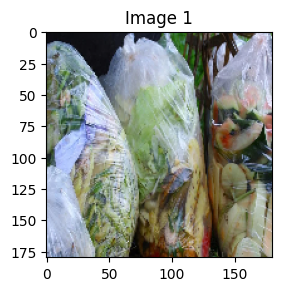

In [ ]:
plt.subplot(1,2,1)
plt.imshow(image_arr1)
plt.title('Image 1')

# plt.subplot(1,2,2)
# plt.imshow(image_arr1,label='Image 2')
# plt.title('Image 2')

# plt.legend()
plt.show()

In [ ]:
result1 = temp.predict(image_fin1)

1/1 [==============================] - 0s 68ms/step


In [ ]:
result1

array([[5.9516797e-10, 1.2661212e-03, 1.2813731e-09, 9.9432135e-01,
        5.5879346e-12, 4.4031674e-03, 8.5252702e-07, 8.1856060e-06,
        3.2377014e-07]], dtype=float32)

In [ ]:
result1.sort()

In [ ]:
result1

array([[5.5879346e-12, 5.9516797e-10, 1.2813731e-09, 3.2377014e-07,
        8.5252702e-07, 8.1856060e-06, 1.2661212e-03, 4.4031674e-03,
        9.9432135e-01]], dtype=float32)